In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import requests
import os
import numpy as np

import torch
from torchvision import models
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax
from torch.optim import Adam,lr_scheduler
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset

from utils_d import *

device = torch.device("cuda:0")

import sys
sys.path.append(r'E:\codes\python\area51m\pytorch_deeplab_xception')
from pytorch_deeplab_xception.modeling import deeplab

import os
os.environ['TORCH_HOME'] = r'E:\data\MODELS' 

In [2]:
num_c = 8

dl = deeplab.DeepLab(num_classes=num_c,backbone = 'resnet').to(device)

for name, param in dl.named_parameters():                
    if name.startswith('backbone'):
        param.requires_grad = False

In [3]:
image_size = (900,900)

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ColorJitter(brightness = 0.15,
                                                       saturation = 0.1,
                                                       hue = 0.01,
                                                       contrast = 0.15),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [4]:
data = pd.read_csv(r'E:\UCL\Dissertation\label\lb_2.csv')

dataset_train = Segdata(transform,image_size,
                        r'lb_2.csv',r'E:\UCL\Dissertation\label',['input','download'])

dataset_test = Segdata(transform,image_size,
                       r'lb_test.csv',r'E:\UCL\Dissertation\label',['input_test','download_test'])

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=6, 
                                         shuffle=True, num_workers=0,drop_last  = True)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, num_workers=0,drop_last  = False)

In [ ]:
freq = 1/get_frequency(data,image_size,num_c,r'\\DESKTOP-lhj25h0\E\UCL\Dissertation\label','download')

freq_norm = torch.full((num_c,1),1/num_c).to(device)

In [5]:
plist = [
         {'params': dl.parameters(),'lr':1e-2}
         ]

criterion = CrossEntropyLoss(ignore_index = 0,weight = torch.log(freq)/torch.log(freq).sum())
#criterion = CrossEntropyLoss(ignore_index = 0)

optimizer = Adam(params=plist)
        
scheduler = lr_scheduler.StepLR(optimizer, step_size=50,gamma=0.1)

loss_list = []

best_val_loss = float('inf')

n_epoch = 100

In [6]:
for epoch in range(n_epoch):
    training_loss,training_iou = train(dl,dataloader_train,optimizer,criterion,loss_list,num_c)
    val_loss,val_iou = evaluate(dl,dataloader_test,criterion,num_c)
    scheduler.step()
    print('finished {0}th training'.format(epoch+1))
    print('training loss: {0}, training iou: {1}'.format(training_loss.item(),training_iou))
    print('validation loss: {0}, validation iou: {1}'.format(val_loss.item(),val_iou))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(dl.state_dict(), r'E:\UCL\Dissertation\label\trained_models\model_deeplabv3+resnet_2_900_withoutw_best.pt')

finished 1th training
training loss: 0.5187213907639185, training iou: 0.3134067779266216
validation loss: 0.28947727996855976, validation iou: 0.3350512957479709
finished 2th training
training loss: 0.20809623350699744, training iou: 0.3614760031561574
validation loss: 0.17648487193509937, validation iou: 0.39407499775581617
finished 3th training
training loss: 0.1606035535534223, training iou: 0.38496701458877747
validation loss: 0.13431504797190427, validation iou: 0.38308194017356983
finished 4th training
training loss: 0.1573098972439766, training iou: 0.40597711697017497
validation loss: 0.12277443539351225, validation iou: 0.4594817873889552
finished 5th training
training loss: 0.11852767368157704, training iou: 0.4762488557493631
validation loss: 0.10391321843490005, validation iou: 0.522717252035453
finished 6th training
training loss: 0.09608140587806702, training iou: 0.5180669192141684
validation loss: 0.09062658315524459, validation iou: 0.5376897034721222
finished 7th tra

finished 51th training
training loss: 0.024500558525323866, training iou: 0.8091878185333626
validation loss: 0.08349736698437482, validation iou: 0.6372364104508772
finished 52th training
training loss: 0.024396420766909916, training iou: 0.7947710247502104
validation loss: 0.07911506812088191, validation iou: 0.6446551389789152
finished 53th training
training loss: 0.023487959615886213, training iou: 0.7909303132013344
validation loss: 0.08230901679489762, validation iou: 0.6578580804655572
finished 54th training
training loss: 0.021870110121866067, training iou: 0.8214318948738877
validation loss: 0.08339151453692466, validation iou: 0.6500652551383753
finished 55th training
training loss: 0.020991444277266662, training iou: 0.8314690556000629
validation loss: 0.07780977205839008, validation iou: 0.6564693723885691
finished 56th training
training loss: 0.020650904687742392, training iou: 0.8272261348895713
validation loss: 0.08148448148276657, validation iou: 0.6512337153651235
fini

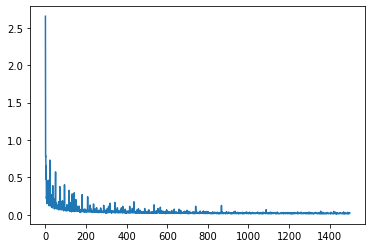

In [7]:
plt.plot(loss_list)

In [8]:
torch.save(dl.state_dict(), r'E:\UCL\Dissertation\label\trained_models\model_deeplabv3+resnet_2_900_withoutw_last.pt')